In [1]:
import pandas as pd
import tensorflow as tf
from transformers import AutoTokenizer
import re
from transformers import AdamWeightDecay
from datasets import Dataset
import math
import numpy as np
from transformers import DataCollatorForSeq2Seq
from transformers import TFAutoModelForSeq2SeqLM
import torch
import matplotlib.pyplot as plt
import evaluate

2023-10-11 13:58:11.854982: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 13:58:15.980856: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tf.config.experimental.list_physical_devices(device_type='GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def json_to_dataset(filename):
    f = open(filename)
    df = pd.read_json(f)
    print(df.head())
    f.close()
    df['news'] = df['news'].apply(lambda x: re.sub(r'\([^)]*\)', '', x))
    #df = df.iloc[:10000]
    print(df.columns)
    print(df.head)
    dataset = Dataset.from_pandas(df)
    dataset = dataset.train_test_split(test_size=0.2)
    return dataset

In [4]:
train_data = json_to_dataset('Train_Headline_Generation.json')

                                                news  \
0  (Oct 7, 2014  12:40 PM CDT) As of Jan. 1, Walm...   
1  (Oct 29, 2013  8:15 AM CDT) Dax Shepard and Kr...   
2  (Mar 6, 2016  10:50 AM) Nancy Reagan, the help...   
3  (Aug 15, 2008  5:11 AM CDT) American Airlines ...   
4  (Apr 18, 2016  1:02 PM CDT) Ingrid Lyne, the S...   

                                            headline  
0   30K Walmart Part-Timers to Lose Health Insurance  
1     Dax Shepard: Wedding to Kristen Bell Cost $142  
2                            Nancy Reagan Dead at 94  
3  American Airlines Faces $7M Fine for Safety Vi...  
4   $222K Raised for Kids of Mom Dismembered on Date  
Index(['news', 'headline'], dtype='object')
<bound method NDFrame.head of                                                     news  \
0       As of Jan. 1, Walmart will no longer offer 30...   
1       Dax Shepard and Kristen Bell got married at t...   
2       Nancy Reagan, the helpmate, backstage adviser...   
3       American Ai

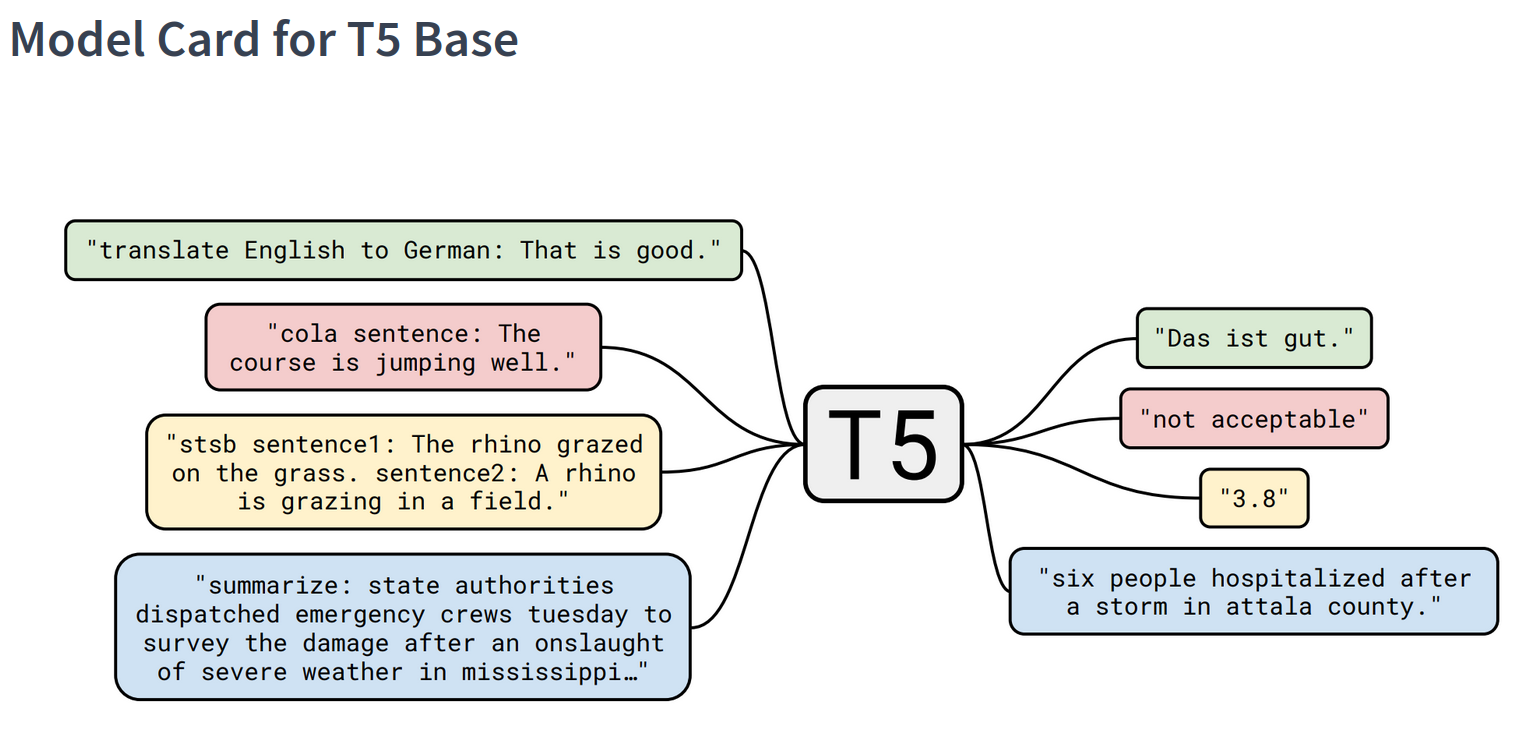

T5 is Text-to-Text-Transfer-Transformer model. It takes input texts for various NLP tasks and outputs the text for that respective task. 

T5 is slightly different from Masked Language Model such as BERT. Masked Language Models are Bidirectional models which use Mask token for each word while T5 replaces multiple consecutive tokens with a single Mask keyword. Since the final objective is to have trained a model that inputs text and outputs text, the targets were designed to produce a sequence, unlike BERT, that tries to output one word (itself). So t5 is suitable for text summarization and headline generation.

In [5]:
model_name = "Michau/t5-base-en-generate-headline"

### The model is based on t5-base and has been trained on a collection of 500k articles with headings. Its purpose is to create a one-line heading suitable for the given article. https://huggingface.co/Michau/t5-base-en-generate-headline

In [6]:
'''
model_names = ["it5/it5-base-headline-generation", 
               "it5/it5-small-headline-generation",
               "it5/mt5-base-headline-generation",
               "it5/mt5-small-headline-generation", 
               "it5/it5-efficient-small-el32-headline-generation",
               "Michau/t5-base-en-generate-headline"]
'''

'\nmodel_names = ["it5/it5-base-headline-generation", \n               "it5/it5-small-headline-generation",\n               "it5/mt5-base-headline-generation",\n               "it5/mt5-small-headline-generation", \n               "it5/it5-efficient-small-el32-headline-generation",\n               "Michau/t5-base-en-generate-headline"]\n'

To prefix the input with a prompt so T5 knows this is a headline generation task

In [7]:
prefix = "headline: "
#max_len = 3024
max_len = 2024
#max_l = 1028
max_l = 128

In [8]:
def preprocess_function(examples):   
    inputs = [prefix + doc for doc in examples["news"]]
    model_inputs = tokenizer(inputs, max_length=max_len, truncation=True)
    labels = tokenizer(text_target=examples["headline"], max_length=max_l, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

To apply the preprocess function over the entire dataset

In [9]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. If you see this, DO NOT PANIC! This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [10]:
tokenized = train_data.map(preprocess_function, batched=True, num_proc=4,
                        remove_columns=train_data['train'].column_names)

Map (num_proc=4):   0%|          | 0/16925 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/4232 [00:00<?, ? examples/s]

To create batches using DataCollatorForSeq2Seq, which dynamically pads the sentences to the longest length in a batch during collation. This is  more efficient than padding the whole dataset to the maximum length. 

In [11]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer,
                                           model=model_name,
                                           return_tensors="tf")
optimizer = AdamWeightDecay(learning_rate=3e-4, weight_decay_rate=0.007)

To load pretrained T5-base michau with AutoModelForSeq2SeqLM

In [12]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_name)

2023-10-11 13:58:57.004725: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:81:00.0, compute capability: 7.0
All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at Michau/t5-base-en-generate-headline.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


To convert datasets to the tf.data.Dataset format 

In [13]:
tf_train_set = model.prepare_tf_dataset(
    tokenized["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_test_set = model.prepare_tf_dataset(
    tokenized["test"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [14]:
model.compile(optimizer=optimizer)

In [13]:
eval_loss = model.evaluate(tf_test_set)
print(f"Pretrained LM Perplexity: {math.exp(eval_loss):.2f}")

265/265 [==============================] - 100s 333ms/step - loss: 2.5198
Pretrained LM Perplexity: 12.43


In [15]:
history = model.fit(x=tf_train_set, validation_data=tf_test_set, batch_size=6, epochs=3)
#model.fit(x=tf_train_set, validation_data=tf_test_set, batch_size=6, epochs=1)
#eval_loss = model.evaluate(tf_test_set)
#print(f"Finetuned Perplexity: {math.exp(eval_loss):.2f}")

Epoch 1/3
1057/1057 [==============================] - 683s 613ms/step - loss: 2.0781 - val_loss: 1.7572
Epoch 2/3
1057/1057 [==============================] - 644s 610ms/step - loss: 1.5876 - val_loss: 1.7086
Epoch 3/3
1057/1057 [==============================] - 634s 600ms/step - loss: 1.2779 - val_loss: 1.7045


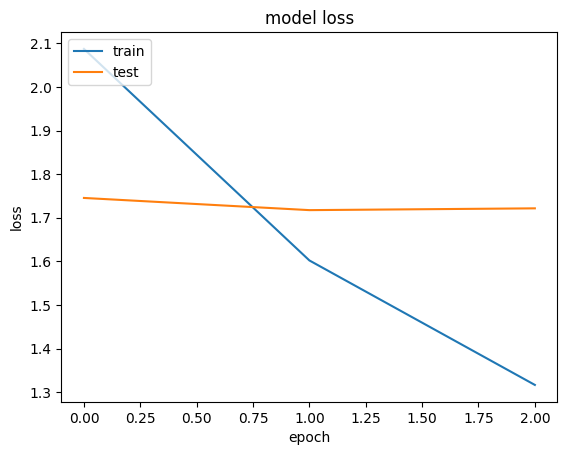

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
f = open('Dev_Headline_Generation.json')
df = pd.read_json(f)
df['news'] = df['news'].apply(lambda x: re.sub(r'\([^)]*\)', '', x))
#df = df.iloc[45:50]
#df = df.iloc[100:500]
f.close()
test_data = Dataset.from_pandas(df)

In [32]:
def t5_predictions(data, tokenizer, model):
    text = prefix + data['news']
    inputs = tokenizer.encode_plus(text, return_tensors="pt").input_ids
    #input_ids = inputs['input_ids'].to(device)
    #attention_masks = inputs['attention_mask']
    
    outputs = model.generate(inputs,
                              max_length = 64, num_beams = 5, early_stopping = True)
    predictions = tokenizer.decode(outputs[0])
    result = re.sub("\<.*?\>","", predictions)
    return result, result1

In [39]:
def t5_predictions(data, tokenizer, model):
    text = prefix + data['news']
    inputs = tokenizer.encode_plus(text, return_tensors="pt").input_ids
    #input_ids = inputs['input_ids'].to(device)
    #attention_masks = inputs['attention_mask']
    
    outputs = model.generate(inputs,top_k=5,do_sample=True,num_return_sequences = 5,
         max_length = 64, num_beams = 5, early_stopping = True)

    prediction1 = tokenizer.decode(outputs[0])
    prediction2 = tokenizer.decode(outputs[1])
    prediction3 = tokenizer.decode(outputs[2])
    prediction4 = tokenizer.decode(outputs[3])
    prediction5 = tokenizer.decode(outputs[4])
    result1 = re.sub("\<.*?\>","", prediction1)
    result2 = re.sub("\<.*?\>","", prediction2)
    result3 = re.sub("\<.*?\>","", prediction3)
    result4 = re.sub("\<.*?\>","", prediction4)
    result5 = re.sub("\<.*?\>","", prediction5)
    return result1, result2, result3, result4, result5

To load the ROUGE metric which stands for Recall-Oriented Understudy for Gisting Evaluation to calculates the similarity between the predicted headlines and actual headlines. ROUGE-N measures the number of matching n-grams between the model-generated text and an actual headline.



In [34]:
rouge = evaluate.load("rouge")

It shows the ratio of the number of unigrams in R that appear also in C over the number of unigrams in R.

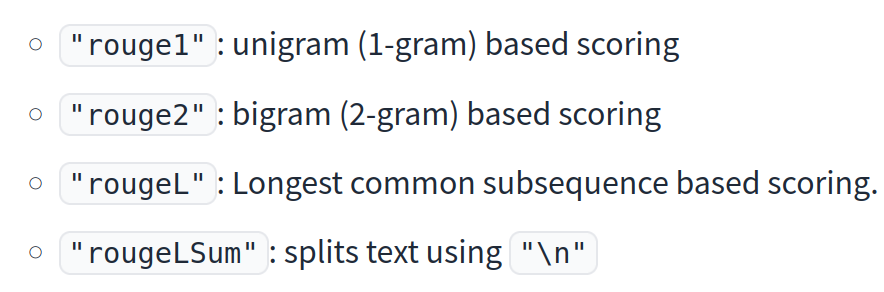

In [ ]:
over50 = 0
over75 = 0
perfect = 0
for i in test_data:
    prediction = t5_predictions(i, tokenizer, model)
    answer = i['headline']
    print("Answer: ", answer)
    print("Prediction: ", prediction)
    results = rouge.compute(predictions=[prediction], references=[answer])
    print(results)
    if results['rougeL'] >= 0.5:
        over50 += 1
    if results['rougeL'] >= 0.75:
        over75 += 1  
    if results['rougeL'] == 1.0:
        perfect += 1
    print("")

In [ ]:
over50 = 0
over75 = 0
perfect = 0
for i in test_data:
    prediction1, prediction2, prediction3, prediction4, prediction5 = t5_predictions(i, tokenizer, model)
    answer = i['headline']
    print("Answer: ", answer)
    print("Prediction1: ", prediction1)
    print("Prediction2: ", prediction2)
    print("Prediction3: ", prediction3)
    print("Prediction4: ", prediction4)
    print("Prediction5: ", prediction5)
    results = rouge.compute(predictions=[prediction1], references=[answer])
    print(results)
    if results['rougeL'] >= 0.5:
        over50 += 1
    if results['rougeL'] >= 0.75:
        over75 += 1  
    if results['rougeL'] == 1.0:
        perfect += 1
    print("")

Answer:  3rd Victim Dead in Quarry Shooting; Manhunt Still On
Prediction1:   3 Dead, 5 Wounded in California Quarry Shooting Spree
Prediction2:   3 Dead, 5 Hurt in California Quarry Shooting Spree
Prediction3:   3 Dead, 5 Wounded at California Quarry Shooting Spree
Prediction4:   3 Dead, 5 Wounded in Shooting Spree in California
Prediction5:   3 Dead in California Quarry Shooting Spree
{'rouge1': 0.4444444444444444, 'rouge2': 0.125, 'rougeL': 0.4444444444444444, 'rougeLsum': 0.4444444444444444}

Answer:  Stocks Up 305 in Election Rally
Prediction1:   Dow Up 305 on Election Day
Prediction2:   Dow Rises 305 on Election Day
Prediction3:   Dow Climbs 305 on Election Day
Prediction4:   Dow Surges 305 on Election Day
Prediction5:   Dow Rises 305 on Election Results
{'rouge1': 0.5, 'rouge2': 0.20000000000000004, 'rougeL': 0.5, 'rougeLsum': 0.5}

Answer:  You Can Watch The Interview at 1pm
Prediction1:   You Can Watch The Interview at 1pm Eastern
Prediction2:   You Can Watch The Interview on Y

In [21]:
print("Over 50: ", over50)
print("Over 75: ", over75)
print("Perfect: ", perfect)

Over 50:  688
Over 75:  174
Perfect:  31


### References:
[1] Prakhar Mishra. 2020. Understanding T5 Model : Text to Text Transfer Transformer Model. Towards Data Science
https://towardsdatascience.com/understanding-t5-model-text-to-text-transfer-transformer-model-69ce4c165023.

[2] Summarization. Huggingface. https://huggingface.co/docs/transformers/tasks/summarization.

[3] Fabio Chiusano. 2022. Two minutes NLP — Learn the ROUGE metric by examples. Medium. https://medium.com/nlplanet/two-minutes-nlp-learn-the-rouge-metric-by-examples-f179cc285499.